In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import yaml
from geopy.distance import great_circle
from geopy import Point
import torch
from models.GRU import GRU
from models.GC_GRU import GC_GRU
from models.Seq2Seq_GC_GRU import Seq2Seq_GC_GRU
from models.DGC_GRU import DGC_GRU
from dataset.SpatioTemporalDataset import SpatioTemporalDataset
from dataset.TemporalDataset import TemporalDataset
from graph import Graph
from utils import load_model
from datetime import datetime

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()

In [2]:
proj_dir = os.path.abspath('')
sys.path.append(proj_dir)
config_fp = os.path.join(proj_dir, 'config.yaml')

with open(config_fp, 'r') as f:
    config = yaml.safe_load(f)

# ------------- Config parameters start ------------- #
data_dir = config['filepath']['data_dir']
model_dir = config['filepath']['model_dir']
bihar_pkl_fp = data_dir + config['filepath']['bihar_pkl_fp']
bihar_npy_fp = data_dir + config['filepath']['bihar_npy_fp']
bihar_locations_fp = data_dir + config['filepath']['bihar_locations_fp']
china_npy_fp = data_dir + config['filepath']['china_npy_fp']
china_locations_fp = data_dir + config['filepath']['china_locations_fp']
bihar_map_fp = data_dir + config['filepath']['bihar_map_fp']

batch_size = int(config['train']['batch_size'])
num_epochs = int(config['train']['num_epochs'])
# forecast_window = int(config['train']['foreca st_window'])
forecast_window = 12
hist_window = int(config['train']['hist_window'])
hidden_dim = int(config['train']['hidden_dim'])
lr = float(config['train']['lr'])
model_type = config['train']['model']

update = int(config['dataset']['update'])
data_start = config['dataset']['data_start']
data_end = config['dataset']['data_end']

train_start = config['split']['train_start']
train_end = config['split']['train_end']
val_start = config['split']['val_start']
val_end = config['split']['val_end']
test_start = config['split']['test_start']
test_end = config['split']['test_end']

num_locs = 511
# ------------- Config parameters end   ------------- #

In [8]:
china_pm25 = np.load(china_npy_fp)[:, :, -1].flatten()
bihar_pm25 = np.load(bihar_npy_fp)[:, :, -1].flatten()

china_avg, bihar_avg = china_pm25.mean(), bihar_pm25.mean()
china_avg, bihar_avg

(52.46937215427194, 105.63217922057939)

In [10]:
bs, fw, nc, hd = 2, 4, 3, 2

x = torch.rand(size=(bs, fw, nc, hd))
y = torch.rand(size=(bs, nc, hd))

z = x.permute(0, 2, 1, 3).contiguous()
z = z.view(-1, fw, hd)
y = y.view(-1, hd, 1)

e = torch.bmm(z, y)
print(y.size(), z.size(), e.size())
e = e.view(bs, nc, fw)
alpha = torch.softmax(e, dim=2).view(bs*nc, fw, 1)
print(e.size(), alpha.size())

res = torch.einsum('bij,bjk->bk', alpha, z).view(bs, nc, -1)
print(res.size())

torch.Size([6, 2, 1]) torch.Size([6, 4, 2]) torch.Size([6, 4, 1])
torch.Size([2, 3, 4]) torch.Size([6, 4, 1])
torch.Size([2, 3, 2])


## Train / Test Data Mean and Variance

In [3]:
def get_indices(start_date, end_date, data_start):
    start_idx = (datetime(*start_date) - datetime(*data_start)).days * (24//update)
    end_idx = (datetime(*end_date) - datetime(*data_start)).days * (24//update)

    return start_idx, end_idx

def get_mean_std(arr, start_idx, end_idx):

    arr = arr[start_idx: end_idx+1]
    pm25 = arr.reshape(-1, arr.shape[-1])[:, -1]
    return pm25.mean().round(4), pm25.std().round(4)

In [4]:
npy_data = np.load(bihar_npy_fp)

train_start_idx, train_end_idx = get_indices(train_start, train_end, data_start)
val_start_idx, val_end_idx = get_indices(val_start, val_end, data_start)
test_start_idx, test_end_idx = get_indices(test_start, test_end, data_start)

train_pm25_mean, train_pm25_std = get_mean_std(npy_data, train_start_idx, train_end_idx)
val_pm25_mean, val_pm25_std = get_mean_std(npy_data, val_start_idx, val_end_idx)
test_pm25_mean, test_pm25_std = get_mean_std(npy_data, test_start_idx, test_end_idx)

In [5]:
print(train_pm25_mean, train_pm25_std)
print(val_pm25_mean, val_pm25_std)
print(test_pm25_mean, test_pm25_std)

92.9271 89.6934
204.834 106.553
203.076 105.5037


## Evaluating Stats and getting the plots

In [6]:
def get_info():
    if model_type in {'GRU', 'LSTM'}:
        train_data = TemporalDataset(bihar_npy_fp, forecast_window, hist_window, train_start, train_end, data_start, update)
        val_data = TemporalDataset(bihar_npy_fp, forecast_window, hist_window, val_start, val_end, data_start, update)
        test_data = TemporalDataset(bihar_npy_fp, forecast_window, hist_window, test_start, test_end, data_start, update)

    elif model_type in {'GC_GRU', 'Seq2Seq_GC_GRU', 'DGC_GRU'}:
        graph = Graph(bihar_locations_fp)

        train_data = SpatioTemporalDataset(bihar_npy_fp, forecast_window, hist_window, train_start, train_end, data_start, update, graph.adj_mat)
        val_data = SpatioTemporalDataset(bihar_npy_fp, forecast_window, hist_window, val_start, val_end, data_start, update, graph.adj_mat)
        test_data = SpatioTemporalDataset(bihar_npy_fp, forecast_window, hist_window, test_start, test_end, data_start, update, graph.adj_mat)

    in_dim, city_num = train_data.feature.shape[-1], train_data.feature.shape[-2]

    if model_type == 'GRU':
        model = GRU(in_dim, hidden_dim, city_num, hist_window, forecast_window, batch_size, device)
    elif model_type == 'GC_GRU':
        model = GC_GRU(in_dim, hidden_dim, city_num, hist_window, forecast_window, batch_size, device, graph.adj_mat)
    elif model_type == 'Seq2Seq_GC_GRU':
        model = Seq2Seq_GC_GRU(in_dim, hidden_dim, city_num, hist_window, forecast_window, batch_size, device, graph.adj_mat)
    elif model_type == 'DGC_GRU':
        model = DGC_GRU(in_dim, hidden_dim, city_num, hist_window, forecast_window, batch_size, device, graph.adj_mat, graph.angles)
    else:
        raise Exception('Wrong model name!')

    return train_data, val_data, test_data, model

In [7]:
model_state_dict, _, train_losses, test_losses = load_model(f'{model_dir}/{model_type}_{hist_window}_{forecast_window}.pth.tar')

train_data, val_data, test_data, model = get_info()
model.load_state_dict(model_state_dict)
model.to(device)
pm25_mean, pm25_std = train_data.pm25_mean, train_data.pm25_std

train_loader = torch.utils.data.DataLoader(train_data, drop_last=True, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, drop_last=True, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, drop_last=True, batch_size=batch_size, shuffle=False)

In [8]:
def test(model, loader, pm25_mean, pm25_std):
    model.eval()
    test_loss = 0
    preds, labels = np.zeros((batch_size, forecast_window, num_locs, 1)), np.zeros((batch_size, forecast_window, num_locs, 1))

    y, y_hat = np.array([]), np.array([])

    for batch_idx, data in enumerate(loader):
        
        features, pm25 = data
        pm25 = pm25.to(device)

        pm25_label = pm25[:, hist_window:]
        pm25_hist = pm25[:, :hist_window]

        pm25_preds = model(features, pm25_hist)

        loss = criterion(pm25_label, pm25_preds)
        test_loss += loss.item()

        pm25_label = pm25_label * pm25_std + pm25_mean
        pm25_preds = pm25_preds * pm25_std + pm25_mean
        pm25_label, pm25_preds = pm25_label.detach().cpu().numpy(), pm25_preds.detach().cpu().numpy()

        labels, preds = pm25_label[:, :, 0, 0], pm25_preds[:, :, 0, 0]

        if y.shape[0] == 0:
            y, y_hat = labels, preds
        else:
            y, y_hat = np.concatenate((y, labels), axis=0), np.concatenate((y_hat, preds), axis=0)


    return y, y_hat

In [9]:
def get_values(model, loader, pm25_mean, pm25_std):
    labels, preds = test(model, loader, pm25_mean, pm25_std)
    print(labels.shape, preds.shape)

    y, y_hat = np.zeros((labels.shape[0] + forecast_window - 1)), np.zeros((preds.shape[0] + forecast_window - 1))
    freq = np.zeros((labels.shape[0] + forecast_window - 1))

    for i, (l, p) in enumerate(zip(labels, preds)):
        y[i:i+forecast_window] += l
        y_hat[i:i+forecast_window] += p
        freq[i:i+forecast_window] += 1

    y, y_hat = np.divide(y, freq), np.divide(y_hat, freq)
    return y, y_hat

In [10]:
HOUR_AVG = 3

train_labels, train_preds = get_values(model, train_loader, pm25_mean, pm25_std)
val_labels, val_preds = get_values(model, val_loader, pm25_mean, pm25_std)
test_labels, test_preds = get_values(model, test_loader, pm25_mean, pm25_std)

train_len, val_len, test_len = len(train_labels) - len(train_labels) % HOUR_AVG, len(val_labels) - len(val_labels) % HOUR_AVG,\
                        len(test_labels) - len(test_labels) % HOUR_AVG

train_labels, train_preds = train_labels[:train_len], train_preds[:train_len]
val_labels, val_preds = val_labels[:val_len], val_preds[:val_len]
test_labels, test_preds = test_labels[:test_len], test_preds[:test_len]

train_labels, train_preds = train_labels.reshape(-1, HOUR_AVG), train_preds.reshape(-1, HOUR_AVG)
train_labels, train_preds = np.mean(train_labels, axis=1), np.mean(train_preds, axis=1)

val_labels, val_preds = val_labels.reshape(-1, HOUR_AVG), val_preds.reshape(-1, HOUR_AVG)
val_labels, val_preds = np.mean(val_labels, axis=1), np.mean(val_preds, axis=1)

test_labels, test_preds = test_labels.reshape(-1, HOUR_AVG), test_preds.reshape(-1, HOUR_AVG)
test_labels, test_preds = np.mean(test_labels, axis=1), np.mean(test_preds, axis=1)

(5824, 12) (5824, 12)
(288, 12) (288, 12)
(320, 12) (320, 12)


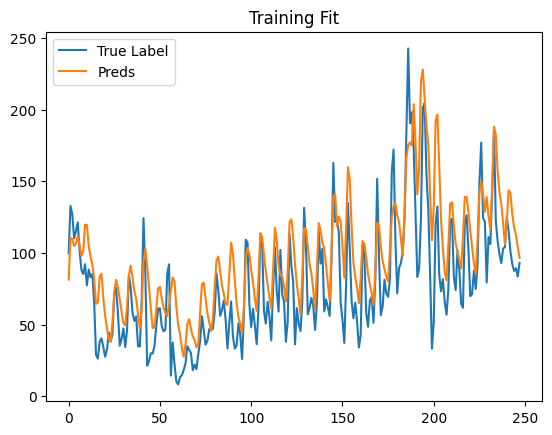

In [15]:
plt.plot(train_labels[-248:], label='True Label')
plt.plot(train_preds[-248:], label='Preds')
plt.legend()
plt.title("Training Fit")
# plt.ylim(0, 300)
plt.show()

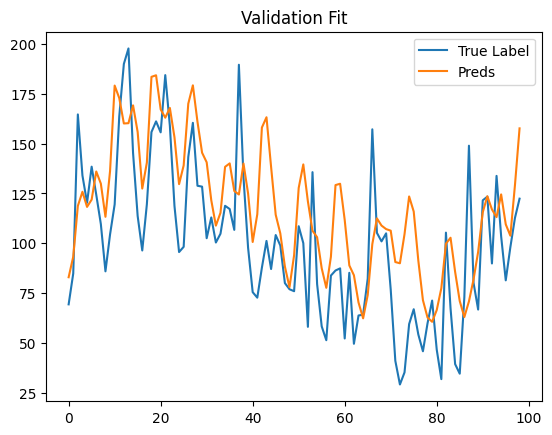

In [12]:
plt.plot(val_labels, label='True Label')
plt.plot(val_preds, label='Preds')
plt.legend()
plt.title("Validation Fit")
# plt.ylim(0, 300)
plt.show()

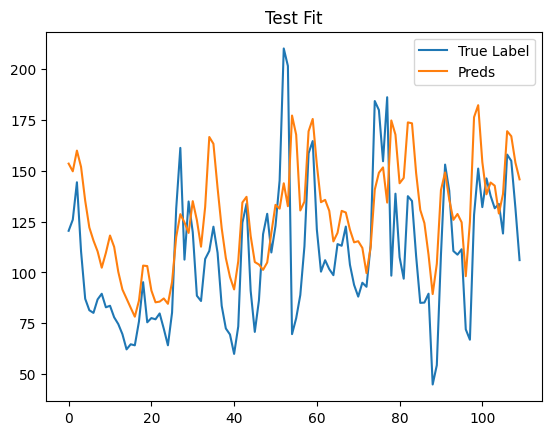

In [13]:
plt.plot(test_labels, label='True Label')
plt.plot(test_preds, label='Preds')
plt.legend()
plt.title("Test Fit")
# plt.ylim(0, 300)
plt.show()